In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [4]:
data = pd.read_csv('../data/creditcard.csv')
data.head(5)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

# 信用卡欺诈检测流水线模型设计
本流程涵盖数据划分、标准化、类别不均衡处理、GPU训练等步骤。

In [17]:
# 1. 数据准备与划分（分为训练、验证、测试集，保证类别分布一致）
from sklearn.model_selection import train_test_split

X = data[[f'V{i}' for i in range(1, 29)]]
y = data['Class']

# 先划分训练+验证和测试集
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
# 再划分训练和验证集
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42)

print('训练集样本数:', len(X_train))
print('验证集样本数:', len(X_val))
print('测试集样本数:', len(X_test))

训练集样本数: 182276
验证集样本数: 45569
测试集样本数: 56962


In [18]:
# 2. 标准化特征
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_val_std = scaler.transform(X_val)
X_test_std = scaler.transform(X_test)

In [19]:
# 3. 处理类别不均衡问题（使用权重或采样）
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}
print('类别权重:', class_weights_dict)

类别权重: {0: np.float64(0.5008655700946906), 1: np.float64(289.32698412698414)}


In [20]:
# 4. 构建PyTorch数据集和数据加载器
import torch
from torch.utils.data import TensorDataset, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train_tensor = torch.tensor(X_train_std, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_std, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_std, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512)
test_loader = DataLoader(test_dataset, batch_size=512)

In [21]:
# 5. 构建简单的神经网络模型并在GPU上训练
import torch.nn as nn

class FraudNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

model = FraudNet(X_train_tensor.shape[1]).to(device)

# 损失函数使用类别权重
pos_weight = torch.tensor([class_weights_dict[1]/class_weights_dict[0]], device=device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [22]:
# 6. 训练模型（简要流程）
epochs = 5
for epoch in range(epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

Epoch 1/5, Loss: 0.6959
Epoch 2/5, Loss: 0.6938
Epoch 2/5, Loss: 0.6938
Epoch 3/5, Loss: 0.6937
Epoch 3/5, Loss: 0.6937
Epoch 4/5, Loss: 0.6932
Epoch 4/5, Loss: 0.6932
Epoch 5/5, Loss: 0.6935
Epoch 5/5, Loss: 0.6935


In [23]:
# 7. 在测试集上评估模型性能
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch).squeeze().cpu().numpy()
        preds = (outputs > 0.5).astype(int)
        y_pred.extend(preds)
        y_true.extend(y_batch.numpy())

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
print('混淆矩阵:')
print(confusion_matrix(y_true, y_pred))
print('\n分类报告:')
print(classification_report(y_true, y_pred, digits=4))
print('ROC AUC分数:', roc_auc_score(y_true, y_pred))

混淆矩阵:
[[56435   429]
 [   10    88]]

分类报告:
              precision    recall  f1-score   support

         0.0     0.9998    0.9925    0.9961     56864
         1.0     0.1702    0.8980    0.2862        98

    accuracy                         0.9923     56962
   macro avg     0.5850    0.9452    0.6412     56962
weighted avg     0.9984    0.9923    0.9949     56962

ROC AUC分数: 0.9452074337050521


## 总结
本流程实现了数据标准化、分层划分、类别不均衡处理，并在GPU上训练了神经网络模型。可根据实际需求进一步优化模型结构和采样策略。

# 使用XGBoost进行特征筛选与分类

In [24]:
# 1. 随机抽取部分数据（如2万条）用于特征筛选
sample_size = 20000
sample_data = data.sample(n=sample_size, random_state=42)
X_sample = sample_data[[f'V{i}' for i in range(1, 29)]]
y_sample = sample_data['Class']

/usr1/home/s124mdg53_07/anaconda3/envs/FYP/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:16:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr1/home/s124mdg53_07/anaconda3/envs/FYP/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr1/home/s124mdg53_07/anaconda3/envs/FYP/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24449 (\N{CJK UNIFIED IDEOGRAPH-5F81}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr1/home/s124mdg53_07/anaconda3/envs/FYP/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr1/home/s124mdg53_07/anaco

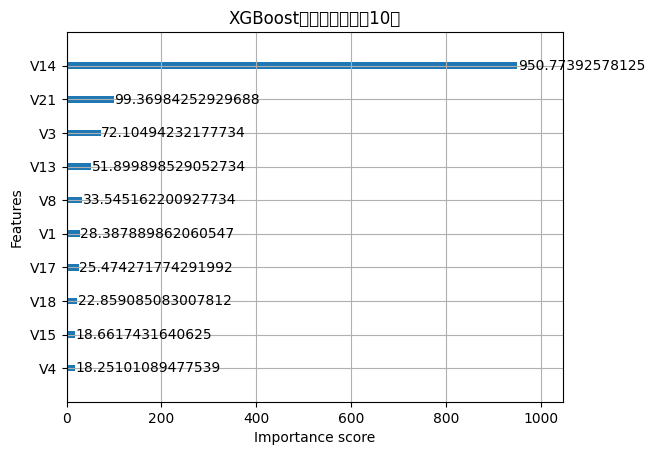

最有价值的特征: ['V14', 'V21', 'V3', 'V13', 'V8', 'V1', 'V17', 'V18']


In [27]:
# 2. 训练XGBoost模型并获取特征重要性
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=100)
xgb_clf.fit(X_sample, y_sample)

import matplotlib.pyplot as plt
xgb.plot_importance(xgb_clf, max_num_features=10, importance_type='gain')
plt.title('XGBoost特征重要性（前10）')
plt.show()

# 获取最重要的前N个特征
feature_importances = xgb_clf.feature_importances_
feature_names = [f'V{i}' for i in range(1, 29)]
importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
importance_df = importance_df.sort_values(by='importance', ascending=False)
top_features = importance_df['feature'].head(8).tolist()
print('最有价值的特征:', top_features)

In [29]:
# 3. 用筛选后的特征重新训练XGBoost分类器并测试
X_train_top = X_train[top_features]
X_val_top = X_val[top_features]
X_test_top = X_test[top_features]

xgb_final = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=class_weights_dict[1]/class_weights_dict[0])
xgb_final.fit(X_train_top, y_train, eval_set=[(X_val_top, y_val)], verbose=False)

y_pred_xgb = xgb_final.predict(X_test_top)

print('XGBoost分类报告:')
print(classification_report(y_test, y_pred_xgb, digits=4))
print('XGBoost混淆矩阵:')
print(confusion_matrix(y_test, y_pred_xgb))
print('XGBoost ROC AUC分数:', roc_auc_score(y_test, y_pred_xgb))

/usr1/home/s124mdg53_07/anaconda3/envs/FYP/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:16:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost分类报告:
              precision    recall  f1-score   support

           0     0.9997    0.9997    0.9997     56864
           1     0.8333    0.8163    0.8247        98

    accuracy                         0.9994     56962
   macro avg     0.9165    0.9080    0.9122     56962
weighted avg     0.9994    0.9994    0.9994     56962

XGBoost混淆矩阵:
[[56848    16]
 [   18    80]]
XGBoost ROC AUC分数: 0.9080225787557566


## 重点关注假阴率（漏检率）重新评价模型
假阴率 = FN / (FN + TP)，即实际为1但预测为0的比例。

In [30]:
# 以XGBoost模型为例，重新评价假阴率
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_xgb)
tn, fp, fn, tp = cm.ravel()
print('混淆矩阵:', cm)
if (fn + tp) > 0:
    false_negative_rate = fn / (fn + tp)
    print(f'假阴率（漏检率）: {false_negative_rate:.4f}')
else:
    print('无正样本，无法计算假阴率')

# 只关注假阴率的评价
print('模型评价重点：假阴率越低越好，假阳率可适当忽略')

混淆矩阵: [[56848    16]
 [   18    80]]
假阴率（漏检率）: 0.1837
模型评价重点：假阴率越低越好，假阳率可适当忽略


# 各维度与Class的相关性分析

In [32]:
# 计算各维度与Class的相关性（皮尔逊相关系数）
corrs = data[[f'V{i}' for i in range(1, 29)] + ['Class']].corr()['Class'].drop('Class')
print(corrs.sort_values(ascending=False))

V11    0.154876
V4     0.133447
V2     0.091289
V21    0.040413
V19    0.034783
V20    0.020090
V8     0.019875
V27    0.017580
V28    0.009536
V26    0.004455
V25    0.003308
V22    0.000805
V23   -0.002685
V15   -0.004223
V13   -0.004570
V24   -0.007221
V6    -0.043643
V5    -0.094974
V9    -0.097733
V1    -0.101347
V18   -0.111485
V7    -0.187257
V3    -0.192961
V16   -0.196539
V10   -0.216883
V12   -0.260593
V14   -0.302544
V17   -0.326481
Name: Class, dtype: float64


/usr1/home/s124mdg53_07/anaconda3/envs/FYP/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21508 (\N{CJK UNIFIED IDEOGRAPH-5404}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr1/home/s124mdg53_07/anaconda3/envs/FYP/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32500 (\N{CJK UNIFIED IDEOGRAPH-7EF4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr1/home/s124mdg53_07/anaconda3/envs/FYP/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr1/home/s124mdg53_07/anaconda3/envs/FYP/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 19982 (\N{CJK UNIFIED IDEOGRAPH-4E0E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr1/home/s124mdg53_07/anaconda3/envs/FYP/lib/p

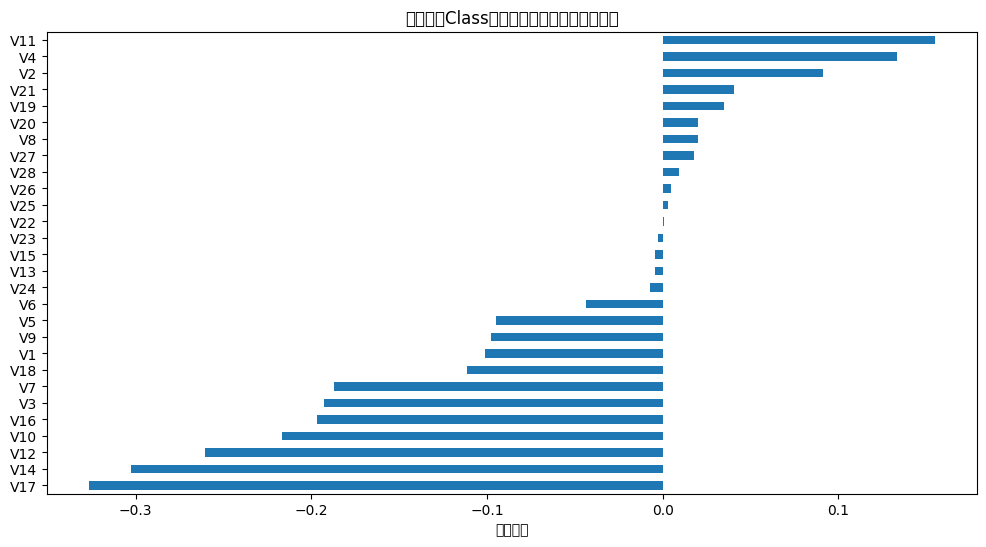

In [33]:
# 可视化相关性（条形图）
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
corrs.sort_values().plot(kind='barh')
plt.title('各维度与Class的相关性（皮尔逊相关系数）')
plt.xlabel('相关系数')
plt.show()

In [36]:
data['Time']


0              0.0
1              0.0
2              1.0
3              1.0
4              2.0
            ...   
284802    172786.0
284803    172787.0
284804    172788.0
284805    172788.0
284806    172792.0
Name: Time, Length: 284807, dtype: float64

# 生成均衡数据集（重采样）

In [37]:
# 下采样多数类或上采样少数类，生成均衡数据集
from sklearn.utils import resample

# 分离多数类和少数类
df_majority = data[data['Class'] == 0]
df_minority = data[data['Class'] == 1]

# 上采样少数类
df_minority_upsampled = resample(
    df_minority,
    replace=True,
    n_samples=len(df_majority),
    random_state=42
)

# 合并为新的均衡数据集
data_balanced = pd.concat([df_majority, df_minority_upsampled])
data_balanced = data_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
print('均衡数据集类别分布:')
print(data_balanced['Class'].value_counts())

均衡数据集类别分布:
Class
1    284315
0    284315
Name: count, dtype: int64


# 用均衡数据集训练和测试XGBoost模型

In [38]:
# 划分均衡数据集的训练、验证、测试集
Xb = data_balanced[[f'V{i}' for i in range(1, 29)]]
yb = data_balanced['Class']
Xb_temp, Xb_test, yb_temp, yb_test = train_test_split(Xb, yb, test_size=0.2, stratify=yb, random_state=42)
Xb_train, Xb_val, yb_train, yb_val = train_test_split(Xb_temp, yb_temp, test_size=0.2, stratify=yb_temp, random_state=42)

In [39]:
# 标准化均衡数据集特征
scaler_b = StandardScaler()
Xb_train_std = scaler_b.fit_transform(Xb_train)
Xb_val_std = scaler_b.transform(Xb_val)
Xb_test_std = scaler_b.transform(Xb_test)

In [40]:
# 用全部特征训练XGBoost模型并测试
import xgboost as xgb
xgb_balanced = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_balanced.fit(Xb_train_std, yb_train, eval_set=[(Xb_val_std, yb_val)], verbose=False)
yb_pred = xgb_balanced.predict(Xb_test_std)

print('均衡数据集XGBoost分类报告:')
print(classification_report(yb_test, yb_pred, digits=4))
print('均衡数据集XGBoost混淆矩阵:')
print(confusion_matrix(yb_test, yb_pred))
print('均衡数据集XGBoost ROC AUC分数:', roc_auc_score(yb_test, yb_pred))

/usr1/home/s124mdg53_07/anaconda3/envs/FYP/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:29:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


均衡数据集XGBoost分类报告:
              precision    recall  f1-score   support

           0     1.0000    0.9998    0.9999     56863
           1     0.9998    1.0000    0.9999     56863

    accuracy                         0.9999    113726
   macro avg     0.9999    0.9999    0.9999    113726
weighted avg     0.9999    0.9999    0.9999    113726

均衡数据集XGBoost混淆矩阵:
[[56849    14]
 [    0 56863]]
均衡数据集XGBoost ROC AUC分数: 0.9998768971035646


# 计算均衡数据集的假阴率（漏检率）

In [41]:
cm_b = confusion_matrix(yb_test, yb_pred)
tn_b, fp_b, fn_b, tp_b = cm_b.ravel()
print('均衡数据集混淆矩阵:', cm_b)
if (fn_b + tp_b) > 0:
    false_negative_rate_b = fn_b / (fn_b + tp_b)
    print(f'均衡数据集假阴率（漏检率）: {false_negative_rate_b:.4f}')
else:
    print('无正样本，无法计算假阴率')

均衡数据集混淆矩阵: [[56849    14]
 [    0 56863]]
均衡数据集假阴率（漏检率）: 0.0000
